# Setup

 1. Clone source code from github.  
 2. (optional) Download datasets from Google Drive folder.  
 3. (optional) Modify dataset paths in source code (`pytracking.evaluation.local`). Modify `prroi_pool.functional` to remove Windows only workaround.
 4. (optional) Modify save results paths to point to Google Drive. This way, all results get saved on the go to the cloud folder causing no data loss in case of crashes/timeouts, etc.

## Clone source code

In [ ]:
!git clone https://github.com/mare5x/adnet-rl-vot.git

In [2]:
%cd /content/adnet-rl-vot/

/content/adnet-rl-vot


## Set file paths

In [3]:
%%writefile pytracking/pytracking/evaluation/local.py

from pytracking.evaluation.environment import EnvSettings

def local_env_settings():
    settings = EnvSettings()

    # Set your local paths here.

    settings.davis_dir = ''
    settings.got10k_path = ''
    settings.got_packed_results_path = ''
    settings.got_reports_path = ''
    settings.lasot_path = ''
    settings.network_path = r'/content/adnet-rl-vot/networks/'    # Where tracking networks are stored.
    settings.nfs_path = ''
    settings.otb_path = r''
    settings.result_plot_path = r'/content/adnet-rl-vot/result_plots/'
    settings.results_path = r'/content/adnet-rl-vot/tracking_results/'    # Where to store tracking results
    settings.segmentation_path = r'/content/adnet-rl-vot/segmentation_results/'
    settings.tn_packed_results_path = ''
    settings.tpl_path = ''
    settings.trackingnet_path = ''
    settings.uav_path = ''
    settings.youtubevos_dir = ''
    settings.vot_path = ''
        
    settings.synthetic_path = r'/content/adnet-rl-vot/datasets/synthetic'
    
    return settings

Overwriting pytracking/pytracking/evaluation/local.py


In [4]:
%%writefile pytracking/ltr/admin/local.py

class EnvironmentSettings:
    def __init__(self):
        self.workspace_dir = ''    # Base directory for saving network checkpoints.
        self.tensorboard_dir = self.workspace_dir + '/tensorboard/'    # Directory for tensorboard files.
        self.pretrained_networks = self.workspace_dir + '/pretrained_networks/'
        self.lasot_dir = ''
        self.got10k_dir = ''
        self.trackingnet_dir = ''
        self.coco_dir = ''
        self.lvis_dir = ''
        self.sbd_dir = ''
        self.imagenet_dir = ''
        self.imagenetdet_dir = ''
        self.ecssd_dir = ''
        self.hkuis_dir = ''
        self.msra10k_dir = ''
        self.davis_dir = ''

Overwriting pytracking/ltr/admin/local.py


In [5]:
%%writefile pytracking/ltr/external/PreciseRoIPooling/pytorch/prroi_pool/functional.py
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
# File   : functional.py
# Author : Jiayuan Mao, Tete Xiao
# Email  : maojiayuan@gmail.com, jasonhsiao97@gmail.com
# Date   : 07/13/2018
#
# This file is part of PreciseRoIPooling.
# Distributed under terms of the MIT license.
# Copyright (c) 2017 Megvii Technology Limited.

import torch
import torch.autograd as ag

__all__ = ['prroi_pool2d']


_prroi_pooling = None


def _import_prroi_pooling():
    global _prroi_pooling

    if _prroi_pooling is None:
        try:
            from os.path import join as pjoin, dirname
            from torch.utils.cpp_extension import load as load_extension
            root_dir = pjoin(dirname(__file__), 'src')

            _prroi_pooling = load_extension(
                '_prroi_pooling',
                [pjoin(root_dir, 'prroi_pooling_gpu.c'), pjoin(root_dir, 'prroi_pooling_gpu_impl.cu')],
                verbose=True
            )
        except ImportError:
            raise ImportError('Can not compile Precise RoI Pooling library.')

    return _prroi_pooling


class PrRoIPool2DFunction(ag.Function):
    @staticmethod
    def forward(ctx, features, rois, pooled_height, pooled_width, spatial_scale):
        _prroi_pooling = _import_prroi_pooling()

        assert 'FloatTensor' in features.type() and 'FloatTensor' in rois.type(), \
                'Precise RoI Pooling only takes float input, got {} for features and {} for rois.'.format(features.type(), rois.type())

        pooled_height = int(pooled_height)
        pooled_width = int(pooled_width)
        spatial_scale = float(spatial_scale)

        features = features.contiguous()
        rois = rois.contiguous()
        params = (pooled_height, pooled_width, spatial_scale)

        if features.is_cuda:
            output = _prroi_pooling.prroi_pooling_forward_cuda(features, rois, *params)
            ctx.params = params
            # everything here is contiguous.
            ctx.save_for_backward(features, rois, output)
        else:
            raise NotImplementedError('Precise RoI Pooling only supports GPU (cuda) implememtations.')

        return output

    @staticmethod
    def backward(ctx, grad_output):
        _prroi_pooling = _import_prroi_pooling()

        features, rois, output = ctx.saved_tensors
        grad_input = grad_coor = None

        if features.requires_grad:
            grad_output = grad_output.contiguous()
            grad_input = _prroi_pooling.prroi_pooling_backward_cuda(features, rois, output, grad_output, *ctx.params)
        if rois.requires_grad:
            grad_output = grad_output.contiguous()
            grad_coor = _prroi_pooling.prroi_pooling_coor_backward_cuda(features, rois, output, grad_output, *ctx.params)

        return grad_input, grad_coor, None, None, None


prroi_pool2d = PrRoIPool2DFunction.apply

Overwriting pytracking/ltr/external/PreciseRoIPooling/pytorch/prroi_pool/functional.py


## Install packages

In [ ]:
!pip install torch==1.2.0 torchvision==0.4.0
!pip install opencv-python
!pip install tb-nightly
!pip install visdom
!pip install scikit-image
!pip install tikzplotlib
!pip install gdown
!pip install pycocotools
!pip install lvis
!pip install spatial-correlation-sampler
!pip install jpeg4py 
!sudo apt-get install ninja-build

!pip install git+https://github.com/votchallenge/vot-toolkit-python

## Download VGG-m backbone

In [7]:
!mkdir -p "networks/"
!curl "https://www.vlfeat.org/matconvnet/models/imagenet-vgg-m.mat" -o "networks/imagenet-vgg-m.mat"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  366M  100  366M    0     0  20.8M      0  0:00:17  0:00:17 --:--:-- 22.7M


# Imports

In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("pytracking")
sys.path.append("pytracking/pytracking")
sys.path.append("pytracking/ltr")

In [9]:
import random
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt

from ltr.data.sampler import RandomSequenceSampler
from pytracking.analysis.plot_results import plot_results, print_results, print_per_sequence_results
from pytracking.evaluation import Tracker, trackerlist
from pytracking.evaluation.running import run_sequence, run_dataset

from pytracking.tracker.adnet.utils import *
from pytracking.tracker.adnet.train import *
from pytracking.tracker.adnet.models import ADNet
from pytracking.tracker.adnet.synthetic import *

In [10]:
def evaluate_tracker(dataset, model_path, experiment_name, iters, display_name=None, **kwargs):
    trackers = []
    for i in range(iters):
        tracker = Tracker('adnet', 'only_track', run_id=i, display_name=display_name, params_callback=lambda p: setattr(p, 'model_path', model_path), experiment_name=experiment_name)
        trackers.append(tracker)
    run_dataset(dataset, trackers, **kwargs)
    return trackers 

def rl_plot(x, ax, label, extend=None, only_avg=False, alpha=0.5, avg_alpha=1.0, n_iou=20, **kwargs):
    x = np.array(x)
    if not only_avg:
        p = ax.plot(x, alpha=alpha, **kwargs)
    avg = rolling_average(x, last_k=10)
    iou = x[-n_iou:].mean()
    if not only_avg:
        p = ax.plot(avg, label=f"{label} [{iou:.3f}]", color=p[-1].get_color(), alpha=avg_alpha, **kwargs)
    else:
        p = ax.plot(avg, label=f"{label} [{iou:.3f}]", alpha=avg_alpha, **kwargs)
    if extend:
        ax.plot(np.arange(len(x), extend), [iou] * (extend - len(x)), '--', color=p[-1].get_color(), alpha=avg_alpha, **kwargs)
    return iou


In [11]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'axes.titlesize': 13})
plt.rcParams.update({'axes.titleweight': 'black'})
plt.rcParams.update({'axes.labelsize': 13})

# Tracker

In [12]:
tracker = Tracker("adnet", "default", run_id=None)
params = tracker.get_parameters()
device = torch.device('cuda')

## Visualize dataset

In [13]:
dummy = DummyDataset()
sequence = dummy.get_sequence_list()[0]
dataset = [sequence]
dataset

[Sequence vot_dummy_100_640_480, length=100 frames]

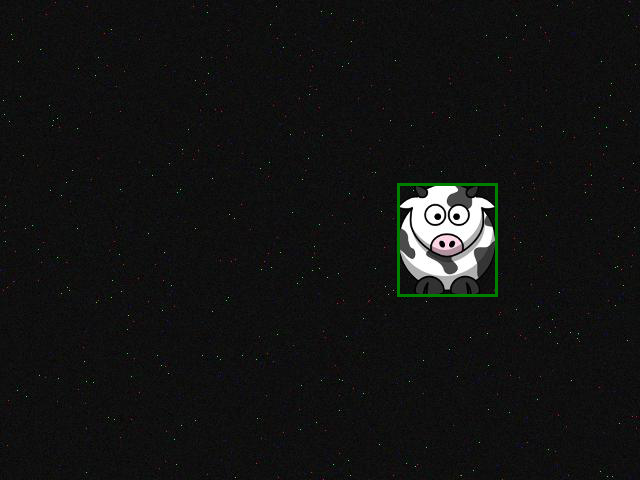

In [14]:
PIL_plot_image(sequence.frames[0], gt=sequence.ground_truth_rect[0])

## Train SL

In [ ]:
trainer = TrainTracker_SL(params, model_path=params.vggm_path, epochs=10, epoch_checkpoint=5, evaluate_performance_=False, experiment_name="SL")
trainer.load_checkpoint()
trainer.train(dataset)

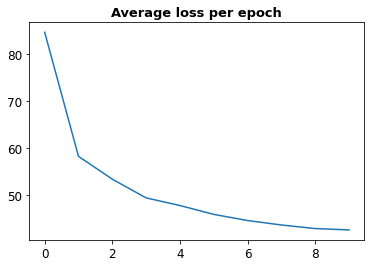

In [16]:
plot_graph_avg(np.array(trainer.stats['avg_epoch_loss']), last_k=None, title="Average loss per epoch")

## Train RL

In [ ]:
start_from = latest_checkpoint(params.checkpoints_path / "SL")
trainer = TrainTracker_RL(params, model_path=start_from, epochs=100, epoch_checkpoint=50, experiment_name="SLRL")
trainer.load_checkpoint()
trainer.train(dataset)

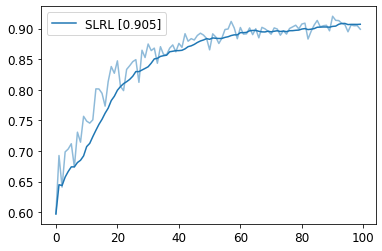

In [18]:
fig, ax = plt.subplots()
rl_plot(trainer.stats['avg_epoch_reward'], ax, label="SLRL")
ax.legend()

## Evaluate

In [19]:
p_target_sl = latest_checkpoint(params.checkpoints_path / "SL")
p_target_slrl = latest_checkpoint(params.checkpoints_path / "SLRL")
print(p_target_sl, p_target_slrl, sep='\n')

/content/adnet-rl-vot/networks/adnet_checkpoints/SL/checkpoint_10.pth
/content/adnet-rl-vot/networks/adnet_checkpoints/SLRL/checkpoint_100.pth


In [20]:
N_RUNS = 1
force = True
trackers = []
trackers.extend(
    evaluate_tracker(
        dataset, 
        params.vggm_path,
        "vggm",
        N_RUNS, 
        display_name=r"$\emptyset$",
        force=force))
trackers.extend(
    evaluate_tracker(
        dataset, 
        p_target_sl,
        "SL",
        N_RUNS, 
        display_name=r"$SL$",
        force=force))
trackers.extend(
    evaluate_tracker(
        dataset, 
        p_target_slrl,
        "SLRL",
        N_RUNS, 
        display_name=r"$SLRL$",
        force=force))

# run_dataset([sequence], trackers, force=force)

Evaluating    1 trackers on     1 sequences
Tracker: adnet only_track 0 ,  Sequence: vot_dummy_100_640_480
Loading imagenet-vgg-m.mat ...
FPS: 24.23176739328006
Done
Evaluating    1 trackers on     1 sequences
Tracker: adnet only_track 0 ,  Sequence: vot_dummy_100_640_480
Loading checkpoint_10.pth ...
FPS: 35.72860021333386
Done
Evaluating    1 trackers on     1 sequences
Tracker: adnet only_track 0 ,  Sequence: vot_dummy_100_640_480
Loading checkpoint_100.pth ...
FPS: 43.417448802126536
Done


100%|██████████| 1/1 [00:00<00:00, 109.75it/s]




Computed results over 1 / 1 sequences

Plotting results over 1 / 1 sequences

Generating plots for: test


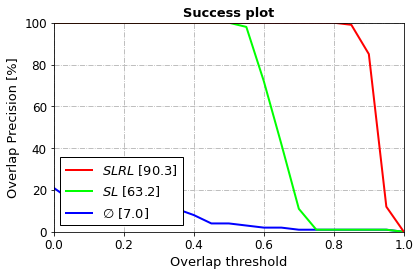

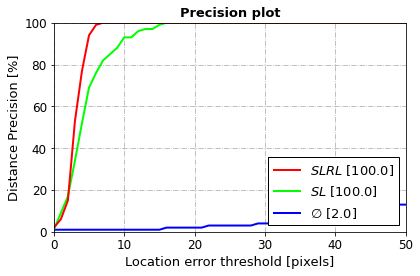

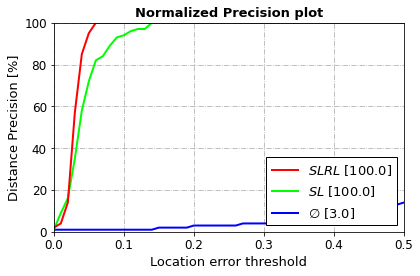

100%|██████████| 1/1 [00:00<00:00, 86.52it/s]




Computed results over 1 / 1 sequences

Reporting results over 1 / 1 sequences

test             | AUC        | OP50       | OP75       | Precision    | Norm Precision    |
$\emptyset$      | 7.05       | 4.00       | 1.00       | 2.00         | 3.00              |
$SL$             | 63.24      | 100.00     | 1.00       | 100.00       | 100.00            |
$SLRL$           | 90.29      | 100.00     | 100.00     | 100.00       | 100.00            |



100%|██████████| 1/1 [00:00<00:00, 59.78it/s]



Computed results over 1 / 1 sequences

                                  | $\emptyset$    | $SL$       | $SLRL$     |
vot_dummy_100_640_480 (ID=0)      | 6.91           | 64.28      | 92.69      |



[Sequence vot_dummy_100_640_480, length=100 frames]

In [22]:
plot_results(trackers, dataset, "test", merge_results=True, plot_types=('success', 'prec', 'norm_prec'), force_evaluation=True, skip_missing_seq=True)
eval_data = print_results(trackers, dataset, "test", merge_results=True, plot_types=('success', 'prec', 'norm_prec'), force_evaluation=True, skip_missing_seq=True)
print_per_sequence_results(trackers, dataset, "test", merge_results=True, force_evaluation=True, skip_missing_seq=True)